In [64]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

%matplotlib inline

In [2]:
# from google.colab import drive
# drive.mount("/content/drive")
# %cd  /content/drive/MyDrive
# %cd  /content/drive/MyDrive/M2BI
# %pwd

Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive/M2BI


'/content/drive/MyDrive/M2BI'

# **Data loading - MNIST Dataset**
---

In [3]:
# Loading the data
train_images = np.load("data/mnist/train_images.npy")
train_labels = np.load("data/mnist/train_labels.npy")
test_images = np.load("data/mnist/test_images.npy")
test_labels = np.load("data/mnist/test_labels.npy")

# **Data visualization**
---

1. We want to firstly visualize some of the images along with their related label.

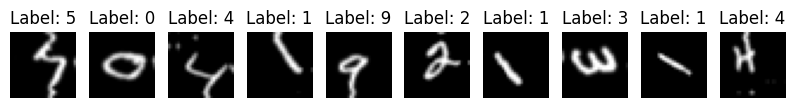

In [4]:
# Visualization of some of the images
def visualiser_images(X, Y, nb_images=10):
    plt.figure(figsize=(10,2))
    for i in range(nb_images):
        plt.subplot(1, nb_images, i+1)
        plt.imshow(X[i], cmap='gray')
        plt.title(f"Label: {Y[i]}")
        plt.axis('off')
    plt.show()

visualiser_images(train_images, train_labels)

2. Secondly, let's see the distribution of each label in the MNIST dataset to check if they are more or less evenly distributed

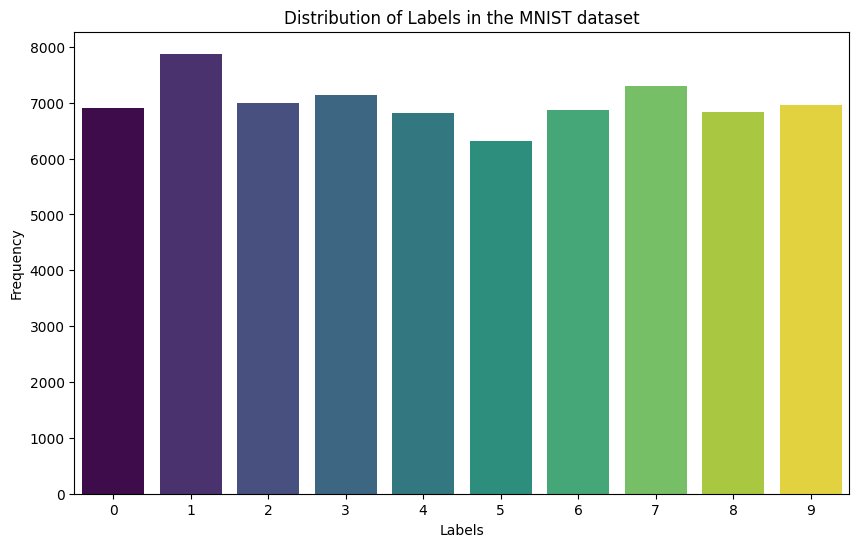

In [5]:
# Combine the train and test labels for a full overview
all_labels = np.concatenate([train_labels, test_labels])

# Create a DataFrame to make plotting easier
label_df = pd.DataFrame(all_labels, columns=['Label'])

# Plot the bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', hue='Label', data=label_df, palette='viridis', legend=False)

# Add title and labels
plt.title('Distribution of Labels in the MNIST dataset')
plt.xlabel('Labels')
plt.ylabel('Frequency')

# Show the plot
plt.show()

3. Lastly, lets check the shape of the data that we have before processing

In [6]:
print("Train Images shape : ", train_images.shape)
print("Train Labels shape : ", train_labels.shape)
print("Test Images shape : ", test_images.shape)
print("Test Labels shape : ", test_labels.shape)

Train Images shape :  (60000, 28, 28, 1)
Train Labels shape :  (60000,)
Test Images shape :  (10000, 28, 28, 1)
Test Labels shape :  (10000,)


In [7]:
# This tells us which data to normalize
print(f"Train images min: {train_images.min()}, max: {train_images.max()}")
print(f"Test images min: {test_images.min()}, max: {test_images.max()}")

Train images min: 0.0, max: 1.0
Test images min: 0, max: 255


# **Data preparation for Deep Learning**
---

In [8]:
num_pixels = train_images.shape[1] * train_images.shape[2]

# Normalize the images
# X_train = train_images.astype('float32') / 255 : train_images are already normalized
X_train = train_images.astype('float32')
X_test = test_images.astype('float32') / 255

# Flatten the 28x28 images into vectors of 784 elements
X_train_flat = X_train.reshape(X_train.shape[0], num_pixels)
X_test_flat = X_test.reshape(X_test.shape[0], num_pixels)

# One hot encoding the target labels
num_classes = 10
Y_train = keras.utils.to_categorical(train_labels, num_classes)
Y_test = keras.utils.to_categorical(test_labels, num_classes)

# Shuffle the data
ns =  X_train_flat.shape[0] # number of examples
np.random.seed()
shuffle_index = np.random.permutation(ns)
X_train_flat, Y_train = X_train_flat[shuffle_index,:], Y_train[shuffle_index,]


**Normalization** :
The images are initially stored with pixel values as integers ranging from 0 to 255. We convert these integers to floating-point numbers of type float32.

---

**Flatten** :  Each image is originally a 2D array of shape (28, 28) pixels. We reshape each image into a 1D array (vector) of length 784 (since 28×28=784)

The -1 in reshape tells NumPy to automatically calculate the number of rows based on the total size of the array and the specified number of columns (28 * 28).

---

**One-hot encoding** : The labels (train_labels and test_labels) are integers representing the digit classes (0 to 9). We convert these integer labels into one-hot encoded vectors of length 10.

For example, the label 3 becomes [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].

One-hot encoding is required when using categorical cross-entropy as the loss function in multi-class classification.

Let's visualise the preprocessed data :

In [9]:
print('X_train_flat shape:', X_train_flat.shape)
print('X_train_flat example:\n', pd.DataFrame(X_train_flat).head())

print('\nX_test_flat shape:', X_test_flat.shape)
print('X_test_flat example:\n', pd.DataFrame(X_test_flat).head())

print('\nY_train_encoded shape:', Y_train.shape)
print('Y_train_encoded example:', Y_train[0])

print('\nY_test_encoded shape:', Y_test.shape)
print('Y_test_encoded example:', Y_test[0])

X_train_flat shape: (60000, 784)
X_train_flat example:
         0         1         2         3         4         5         6    \
0  0.185082  0.185082  0.185082  0.185082  0.185082  0.185082  0.185082   
1  0.112860  0.112860  0.112860  0.112860  0.112860  0.112860  0.112860   
2  0.165009  0.165009  0.165009  0.165009  0.165009  0.165009  0.165009   
3  0.196641  0.196641  0.196641  0.196641  0.196641  0.196641  0.196641   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

        7         8         9    ...       774       775       776       777  \
0  0.185082  0.185082  0.185082  ...  0.823800  0.460170  0.220651  0.185340   
1  0.112860  0.112860  0.112860  ...  0.114544  0.120614  0.119994  0.114257   
2  0.165009  0.165009  0.165009  ...  0.167038  0.165009  0.165009  0.165009   
3  0.196641  0.196641  0.196641  ...  0.196641  0.196641  0.196641  0.196641   
4  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   

        778 

# **1st Model : MLP**
---

## **Creation of the model**

In [10]:
# Construction of MLP model (from project instructions)
model_mlp = Sequential()
model_mlp.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
model_mlp.add(Dense(256, activation='relu')) # 1st hidden layer with 256 neurons
model_mlp.add(Dropout(0.3)) # 30% dropout
model_mlp.add(Dense(128, activation='relu')) # 2nd hidden layer with 128 neurons
model_mlp.add(Dropout(0.3)) # 30% dropout
model_mlp.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))

# Compilation of the model
# # Set a lower learning rate to stabilize training
# optimizer = RMSprop(learning_rate=0.01)  # Try increasing the learning rate
model_mlp.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Model description
model_mlp.summary()

# plot_model(model_mlp, to_file="model.png", show_shapes=True, show_layer_names=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 784)                 │         615,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 850,586 (3.24 MB)

 Trainable params: 850,586 (3.24 MB)

 Non-trainable params: 0 (0.00 B)

## **Model Training**

In [12]:
# Train model
history_mlp = model_mlp.fit(X_train_flat, Y_train, shuffle=True, batch_size=124, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.2766 - loss: 1.9981 - val_accuracy: 0.5978 - val_loss: 1.2006
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.6210 - loss: 1.1475 - val_accuracy: 0.7084 - val_loss: 0.8829
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.7314 - loss: 0.8248 - val_accuracy: 0.7541 - val_loss: 0.7610
Epoch 4/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.7849 - loss: 0.6652 - val_accuracy: 0.7464 - val_loss: 0.8618
Epoch 5/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.8224 - loss: 0.5505 - val_accuracy: 0.7880 - val_loss: 0.6680
Epoch 6/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.8474 - loss: 0.4693 - val_accuracy: 0.7921 - val_loss: 0.6922
Epoch 7/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.8661 - loss: 0.4141 - val_accuracy: 0.7544 - val_loss: 0.7924
Epoch 8/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.8793 - loss: 0.3709 - 

## **Evaluation of the model**

In [58]:
def evaluate_model(model, X_test, Y_test, model_name='Model'):
    """
    This function evaluates the given model using the test data and prints the accuracy and loss.

    Parameters:
    - model: Trained model to be evaluated.
    - X_test: Test features.
    - Y_test: Ground truth labels.

    Returns:
    - evaluation: The result of the model's evaluation (loss and accuracy).
    """

    # Evaluate the model using the test data
    evaluation = model.evaluate(X_test, Y_test)

    # Print accuracy and loss
    print(f"\nModel evaluation {model_name}")
    print("-" * 30)
    print(f"Test Loss:      {evaluation[0]:.6f}")
    print(f"Test Accuracy:  {evaluation[1] * 100:.2f}%")
    print("-" * 30)


In [60]:
evaluate_model(model_mlp, X_test_flat, Y_test, model_name="MLP")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8529 - loss: 1.2690

Model evaluation MLP
------------------------------
Test Loss:      1.147233
Test Accuracy:  86.58%
------------------------------


In [42]:
def plot_history(history, model_name='Model'):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label=f'Train accuracy ({model_name})')
    plt.plot(history.history['val_accuracy'], label=f'Val accuracy ({model_name})')
    plt.title(f'{model_name} accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label=f'Train loss ({model_name})')
    plt.plot(history.history['val_loss'], label=f'Val loss ({model_name})')
    plt.title(f'{model_name} loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    plt.show()

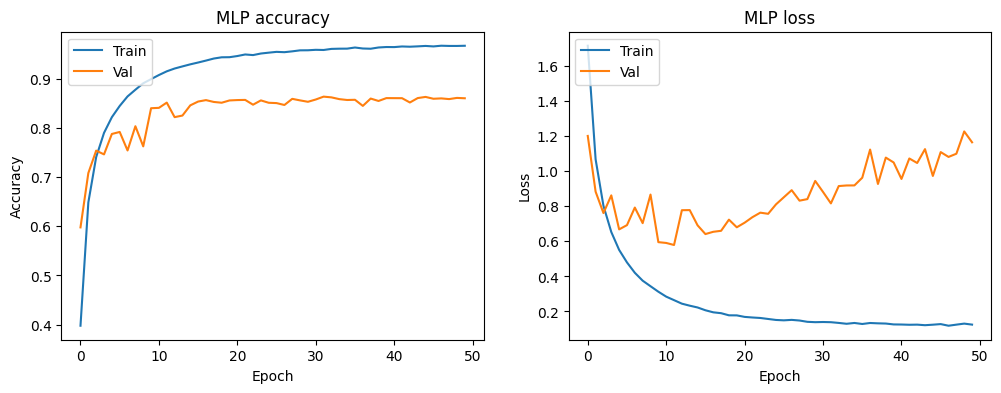

In [43]:
plot_history(history_mlp, model_name='MLP')

**Intepretation** :

**For the "train" dataset** : Both the accuracy and loss graphs reflect a good model with the accuracy that is close to 1.0 and a loss that is close to 0.0.

**For the "validation" dataset** : We can see that the overall accuracy is pretty good (86.6% : 0.86) howevery it stagnates at this value at around 10 epochs. This reflects a possible overfitting from the model. Maybe add more Droupout layers/L2 regularisation layers.
We also see that the val_loss is decreases from 0 to 10 epochs, then increases till the end : Overfitting. This could be due to a low learning rate so maybe increasing it could help as well.

In [63]:
def plot_confusion_matrix(model, X_test, Y_test, model_name='Model'):
    """
    This function generates predictions from a model on the test set,
    processes the results, and plots the confusion matrix.

    Parameters:
    - model: Trained model used for prediction.
    - X_test: Test features (can be flattened or raw as per model input).
    - Y_test: Ground truth labels, can be one-hot encoded or class labels.

    Returns:
    - None (Displays the confusion matrix plot).
    """

    # Step 1: Generate predictions on the test set
    Y_pred = model.predict(X_test)

    # Step 2: Convert predicted probabilities to class labels
    Y_pred_classes = np.argmax(Y_pred, axis=1)

    # Step 3: Check if Y_test is one-hot encoded or not
    if len(Y_test.shape) > 1 and Y_test.shape[1] > 1:
        # Case 1: Y_test is one-hot encoded
        Y_true = np.argmax(Y_test, axis=1)
    else:
        # Case 2: Y_test is already in class labels
        Y_true = Y_test

    # Step 4: Compute the confusion matrix
    conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

    # Step 5: Plot the confusion matrix using seaborn
    plt.figure(figsize=(8, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10))
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


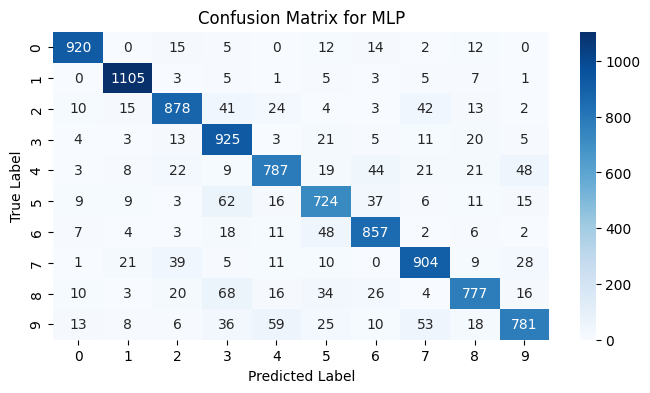

In [50]:
plot_confusion_matrix(model_mlp, X_test_flat, Y_test, model_name='MLP')

# **2nd Model : CNN**
---

## **Data preprocessing**

In [15]:
# Loading the data
train_images = np.load("data/mnist/train_images.npy")
train_labels = np.load("data/mnist/train_labels.npy")
test_images = np.load("data/mnist/test_images.npy")
test_labels = np.load("data/mnist/test_labels.npy")

num_pixels = train_images.shape[1] * train_images.shape[2]

# Normalize the images
# X_train_cnn = train_images.astype('float32') / 255 : train_images are already normalized
X_train_cnn = train_images.astype('float32')
X_test_cnn = test_images.astype('float32') / 255

# One hot encoding the target labels
num_classes = 10
Y_train_cnn = keras.utils.to_categorical(train_labels, num_classes)
Y_test_cnn = keras.utils.to_categorical(test_labels, num_classes)

## **Creation of the model**

In [16]:
num_classes = 10
input_shape = (28, 28, 1)
model = keras.Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Flatten())

model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(num_classes, activation="softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## **Model description**

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │       1,639,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,668,490 (6.36 MB)

 Trainable params: 1,668,490 (6.36 MB)

 Non-trainable params: 0 (0.00 B)

## **Model Training**

In [18]:
batch_size = 64
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train_cnn, Y_train_cnn, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 77s 100ms/step - accuracy: 0.5395 - loss: 1.3308 - val_accuracy: 0.9016 - val_loss: 0.3241
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 79s 97ms/step - accuracy: 0.8988 - loss: 0.3255 - val_accuracy: 0.9283 - val_loss: 0.2295
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 85s 101ms/step - accuracy: 0.9346 - loss: 0.2082 - val_accuracy: 0.9394 - val_loss: 0.1908
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 80s 106ms/step - accuracy: 0.9530 - loss: 0.1487 - val_accuracy: 0.9413 - val_loss: 0.1827
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 83s 108ms/step - accuracy: 0.9644 - loss: 0.1080 - val_accuracy: 0.9498 - val_loss: 0.1643
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 76s 100ms/step - accuracy: 0.9721 - loss: 0.0823 - val_accuracy: 0.9503 - val_loss: 0.1693
Epoch 7/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 101ms/step - accuracy: 0.9787 - loss: 0.0650 - val_accuracy: 0.9560 - val_loss: 0.1498
Epoch 8/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 80s 99ms/step - accuracy: 0.9825 - loss: 0.0

## **Evaluation of the model**

In [61]:
evaluate_model(model, X_test_cnn, Y_test_cnn, model_name="CNN")

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9517 - loss: 0.2320

Model evaluation CNN
------------------------------
Test Loss:      0.191956
Test Accuracy:  95.98%
------------------------------


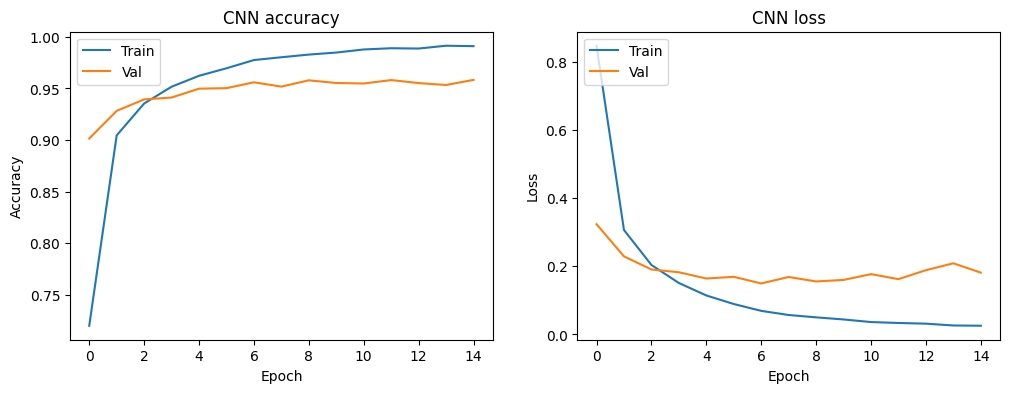

In [45]:
plot_history(history, model_name='CNN')

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


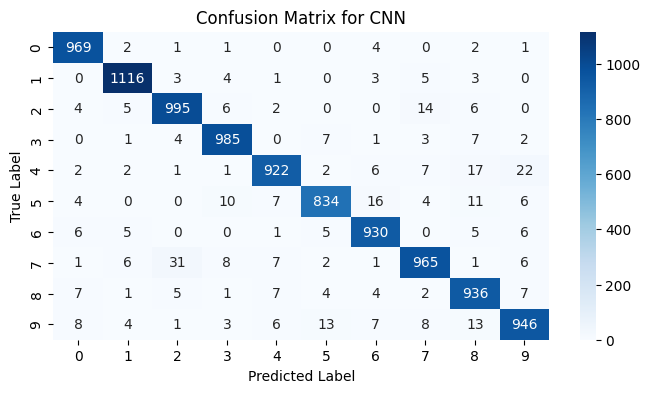

In [51]:
plot_confusion_matrix(model, X_test_cnn, Y_test_cnn, model_name='CNN')

# **Model comparison : MLP vs CNN**

Comparison :

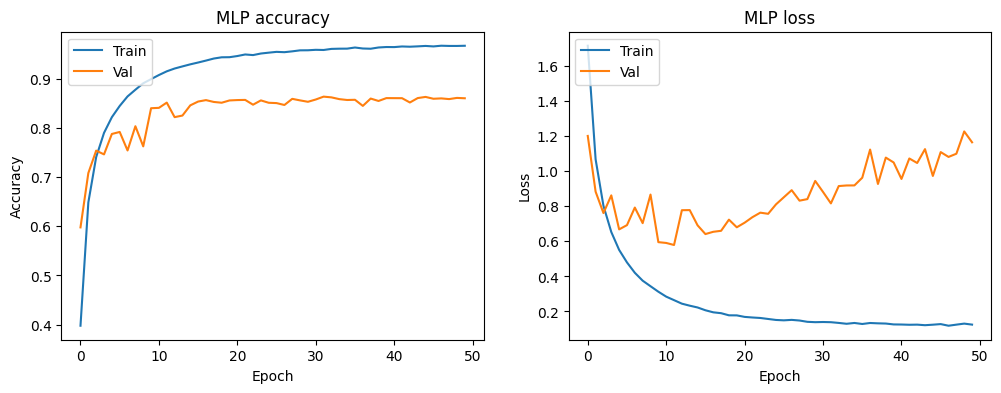

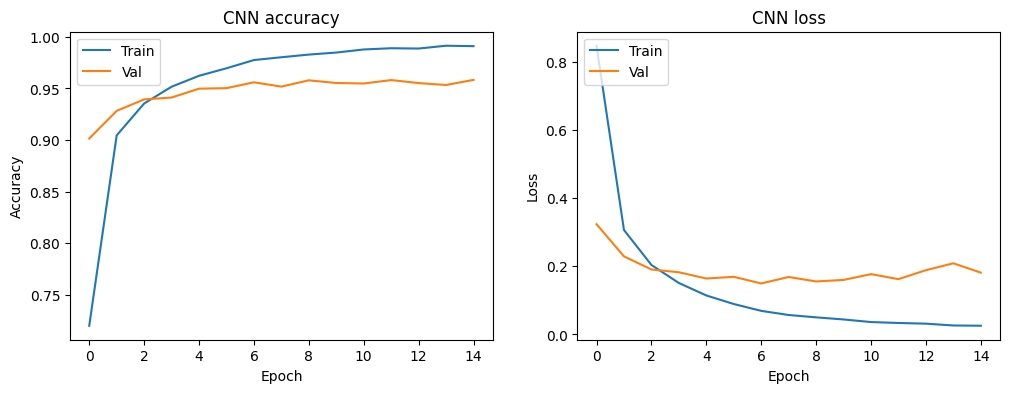

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


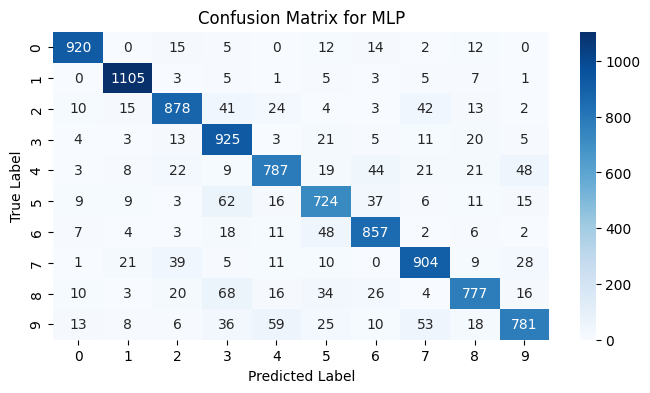

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


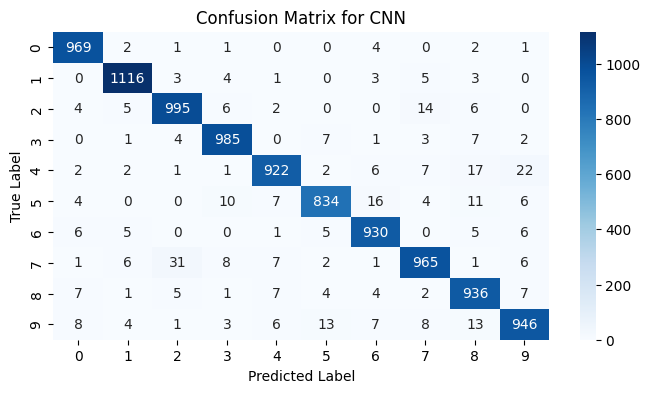

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8529 - loss: 1.2690

Model evaluation MLP
------------------------------
Test Loss:      1.147233
Test Accuracy:  86.58%
------------------------------
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9517 - loss: 0.2320

Model evaluation CNN
------------------------------
Test Loss:      0.191956
Test Accuracy:  95.98%
------------------------------


In [62]:
plot_history(history_mlp, model_name='MLP')
plot_history(history, model_name='CNN')

plot_confusion_matrix(model_mlp, X_test_flat, Y_test, model_name='MLP')
plot_confusion_matrix(model, X_test_cnn, Y_test_cnn, model_name='CNN')

evaluate_model(model_mlp, X_test_flat, Y_test, model_name="MLP")
evaluate_model(model, X_test_cnn, Y_test_cnn, model_name="CNN")